In [12]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
from pyscf.scf.hf import dump_scf_summary
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/usr/local/anaconda3/lib/python3.9/site-packages/pyscf/__init__.py


In [25]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 20", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 4
    nelecas = 2
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

def stat_qmc(etot, filename):
    block_sizes = np.linspace(2,len(etot[discard:])//16, 10, dtype=int)
    reblocks = [len(etot)//s for s in block_sizes]

    plt.figure()
    df = pd.DataFrame([pyq.read_mc_output(filename, warmup=discard, reblock=reblock) for reblock in reblocks])
    df['block_size'] = block_sizes
    plt.plot("block_size",'energytotal_err',data=df, marker='o')
    plt.xlabel("Block size")
    plt.ylabel("Estimated uncertainty (Ha)")

def reblock(e, discard,reblock_size):
    e = e[discard:]
    vals = pyqmc.reblock.reblock(e,int(len(e)/reblock_size))
    e_m  = np.mean(vals, axis=0)
    e_d  = scipy.stats.sem(vals, axis=0)    
    return e_m, e_d

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_he(scf_checkfile)

# mc = run_casci(scf_checkfile, ci_checkfile)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1
LDA
converged SCF energy = -2.82670655418611  <S^2> = 0  2S+1 = 1


In [3]:
from recipes import ABOPTIMIZE, OPTIMIZE
import importlib, recipes
modules = [recipes]
for m in modules:
    importlib.reload(m)

    # Jastrow optimization
for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
print("RUNNING VMC OPTIMIZATION")
# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
recipes.OPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=4, verbose=False)

# Jastrow optimization results
df = pyq.read_opt("sj.hdf5")
df

RUNNING VMC OPTIMIZATION


,energy,iteration,error,fname
0,-2.826775,0,0.012865,sj.hdf5
1,-2.849970,1,0.005290,sj.hdf5
2,-2.884594,2,0.006175,sj.hdf5
3,-2.883310,3,0.005392,sj.hdf5


In [78]:
tstep = 0.001
nconfig = 200
nsteps = 10000
discard = 2000
reblock_size = 50

In [79]:
#PYQMC VMC 
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['vmc_001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC
VMC("scf.hdf5", "vmc_001.hdf5",  verbose=True, nsteps =nsteps, tstep= tstep, nconfig=nconfig)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Mean  etot ,  -2.7687675397514036 +/- 0.00899806996138916
Mean  ee ,  1.0881972682639869 +/- 0.004633025296420595
Mean  ei ,  -7.634441383123878 +/- 0.029069924811780484
Mean  ke ,  3.777476575108488 +/- 0.03375172575357294


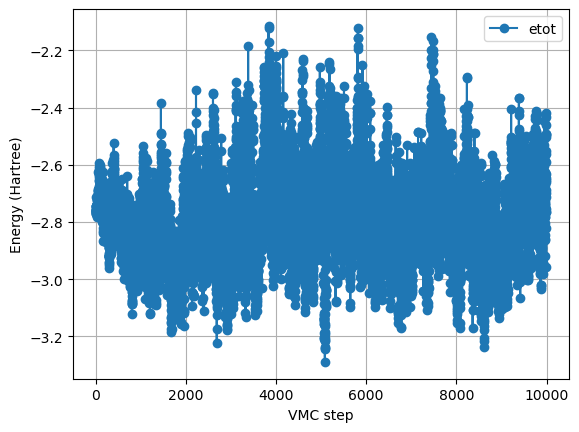

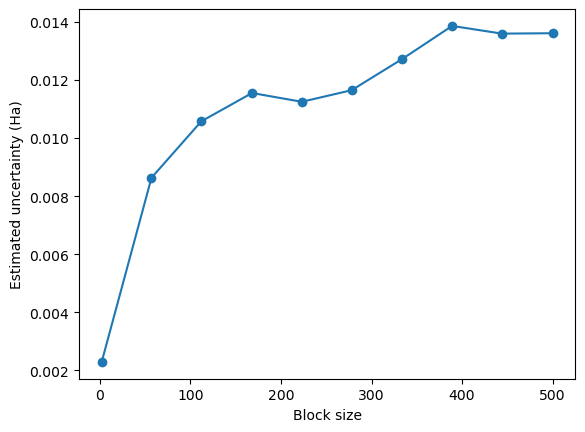

In [80]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

import matplotlib.pyplot as plt
filename = "vmc_001.hdf5"
with h5py.File(filename) as f:
    ee = f['energyee'][...]   
    ei = f['energyei'][...]
    # ii = f['energyii'][...]    
    ke = f['energyke'][...]
    etot = f['energytotal'][...]
# plt.plot(e_est, marker='o', label="E_est")
# plt.plot(e_t, marker='o', label="E_t")
plt.plot(etot, marker='o', label="etot")
# plt.plot(ee, marker='o', label="ee")
# plt.plot(ei, marker='o', label="ei")
# plt.plot(ke, marker='o', label="ke")
# plt.plot(ke+ei, marker='o', label="ke+ei")
# plt.plot(ka-ka[0], marker='o', label="ka")
# plt.plot(kb-kb[0], marker='o', label="kb")

# plt.plot(vxc-vxc[0], marker='o', label="vxc")
plt.legend()
plt.xlabel("VMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()

for e in [etot, ee, ei, ke]:
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]       
    e_m, e_d = reblock(e, discard,reblock_size)
    print("Mean ", name, ", ", e_m, "+/-", e_d)

stat_qmc(etot, filename)

In [81]:
# block_sizes = np.linspace(2,len(etot)//16, 10, dtype=int)
# reblocks = [len(etot)//s for s in block_sizes]
# print(reblocks)
# print(block_sizes)
# df = pd.DataFrame([pyq.read_mc_output("vmc.hdf5", warmup=discard, reblock=reblock) for reblock in reblocks])
# df['block_size'] = block_sizes
# plt.plot("block_size",'energytotal_err',data=df, marker='o')
# plt.xlabel("Block size")
# plt.ylabel("Estimated uncertainty (Ha)")

In [82]:
# #Timestep error tests
# t = [1, 0.3, 0.1, 0.01]
# e_t_vmc = []
# for dt in t:
#     for fname in ['vmc.hdf5', 'dmc.hdf5']:
#         if os.path.isfile(fname):
#             os.remove(fname)    
#     VMC("scf.hdf5", "vmc.hdf5", verbose=True, nsteps =200, tstep=dt, nconfig=200)
#     with h5py.File("vmc.hdf5") as f:
#         etot_t = f['energytotal'][...] 
#     for e in [etot_t]:
#         e_m = np.mean(e[discard:])
#         e_d = np.var(e[discard:])
#         e_t_vmc.append(e_m)



In [83]:
# plt.plot(t, e_t_vmc, '-ok')
# print(e_t_vmc[-1])

In [ ]:
#PYQMC VMC with jastrow
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['vmc-j-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC
VMC("scf.hdf5", "vmc-j-001.hdf5",  load_parameters="sj.hdf5", verbose=True, nsteps =nsteps, tstep= tstep, nconfig=nconfig)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

import matplotlib.pyplot as plt
filename="vmc-j-001.hdf5"
with h5py.File(filename) as f:
    ee_j = f['energyee'][...]   
    ei_j = f['energyei'][...]
    # ii = f['energyii'][...]    
    ke_j = f['energyke'][...]
    etot_j = f['energytotal'][...]
plt.plot(etot_j, marker='o', label="etot")
plt.plot(ee_j, marker='o', label="ee")
plt.plot(ei_j, marker='o', label="ei")
plt.plot(ke_j, marker='o', label="ke")
plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()

for e in [etot_j, ee_j, ei_j, ke_j]:
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]    
    e_m, e_d = reblock(e, discard,reblock_size)
    print("Mean ", name, ", ", e_m, "+/-", e_d)

stat_qmc(etot_j, filename)


In [ ]:
#ABVMC
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['abvmc-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC

# ABDMC("scf.hdf5", "dmc.hdf5", load_parameters="sj.hdf5", ci_checkfile=ci_checkfile, accumulators = {"energy": True}, verbose=False, nsteps = 500, branchtime = 10, tstep= 0.02, nconfig=100)
# ABVMC("scf.hdf5", "dmc.hdf5", load_parameters="sj.hdf5", verbose=False, nsteps = 5000, branchtime = 5, tstep= 0.02, nconfig=500)
ABVMC("scf.hdf5", "abvmc-001.hdf5", verbose=True,  nsteps =nsteps, tstep= tstep, nconfig=nconfig)

In [ ]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
filename="abvmc-001.hdf5"
with h5py.File(filename) as f:
    ee_abvmc = f['energyee'][...]   
    ei_abvmc = f['energyei'][...]
    vh_abvmc = f['energyvh'][...]   
    vxc_abvmc = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abvmc = f['energyii'][...]    
    ke_abvmc = f['energyke'][...]
    ka_abvmc = f['energyka'][...]
    kb_abvmc = f['energykb'][...]   
    ecorr_abvmc = f['energycorr'][...]    
    etot_abvmc = f['energytotal'][...] 
vhxc_abvmc = vh_abvmc + vxc_abvmc
# plt.plot(e_t, marker='o', label="E_t")
plt.plot(etot_abvmc, marker='o', label="etot")
# plt.plot(ii_abvmc, marker='o', label="ii")
# plt.plot(ee_abvmc, marker='o', label="ee")
# plt.plot(ecorr_abvmc, marker='o', label="dft_eig")
# plt.plot(vxc_abvmc, marker='o', label=r"$V_{xc}$")
# plt.plot(vh_abvmc, marker='o', label=r"$V_{h}$")
# plt.plot(vxc_abvmc+vh_abvmc, marker='o', label=r"$V_{hxc}$")
# plt.plot(ecorr_abvmc, marker='o', label=r"$ecorr$")


# plt.plot(ke, marker='o', label="ke")

# plt.plot(ee-eed, marker='o', label="ee-diff")
# plt.plot(ei, marker='o', label="ei")
# plt.plot(eid, marker='o', label="eid")
# plt.plot(eed, marker='o', label="eed")
# plt.plot(ei-eid, marker='o', label="ei-eid")

# eboson=ee-vxc
# plt.plot(eboson, marker='o', label="boson")
# plt.plot(ke, marker='o', label="ke")
# plt.plot(ka-ka[0], marker='o', label="ka")
# plt.plot(kb-kb[0], marker='o', label="kb")

# plt.plot(vxc-vxc[0], marker='o', label="vxc")
plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABVMC')
for e in [etot, etot_abvmc, ee_abvmc, vh_abvmc, vxc_abvmc, ecorr_abvmc, ei_abvmc, vhxc_abvmc, ii_abvmc]:
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]    
    e_m, e_d = reblock(e, discard,reblock_size)
    print("Mean ", name, ", ", e_m, "+/-", e_d)
# e_m2 = np.mean(etot2[discard:])
# e_d2 = np.var(etot2[discard:])

# print("Mean VMC Energy, ", df.iloc[1].energy, "+/-", df.iloc[1].error)
print("LDA Energy, ", mf_lda.energy_tot())
# plt.plot(ed, marker='o', label="ke")

stat_qmc(etot_abvmc, filename)


In [ ]:
#ABVMC with jastrows
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['abvmc-j-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC

ABVMC("scf.hdf5", "abvmc-j-001.hdf5", load_parameters="sj.hdf5", verbose=True,  nsteps =nsteps, tstep= tstep, nconfig=nconfig)

In [ ]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
filename="abvmc-j-001.hdf5"
with h5py.File(filename) as f:
    ee_abvmc_j = f['energyee'][...]   
    ei_abvmc_j = f['energyei'][...]
    vh_abvmc_j = f['energyvh'][...]   
    vxc_abvmc_j = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abvmc_j = f['energyii'][...]    
    ke_abvmc_j = f['energyke'][...]
    ka_abvmc_j = f['energyka'][...]
    kb_abvmc_j = f['energykb'][...]   
    ecorr_abvmc_j = f['energycorr'][...]    
    etot_abvmc_j = f['energytotal'][...] 
vhxc_abvmc_j = vh_abvmc_j + vxc_abvmc_j
# plt.plot(e_t, marker='o', label="E_t")
plt.plot(etot_abvmc_j, marker='o', label="etot")
plt.plot(ii_abvmc_j, marker='o', label="ii")
plt.plot(ee_abvmc_j, marker='o', label="ee")
# plt.plot(ecorr_abvmc, marker='o', label="dft_eig")
# plt.plot(vxc_abvmc, marker='o', label=r"$V_{xc}$")
# plt.plot(vh_abvmc, marker='o', label=r"$V_{h}$")
plt.plot(vxc_abvmc_j+vh_abvmc_j, marker='o', label=r"$V_{hxc}$")
# plt.plot(ecorr_abvmc, marker='o', label=r"$ecorr$")


# plt.plot(ke, marker='o', label="ke")

# plt.plot(ee-eed, marker='o', label="ee-diff")
# plt.plot(ei, marker='o', label="ei")
# plt.plot(eid, marker='o', label="eid")
# plt.plot(eed, marker='o', label="eed")
# plt.plot(ei-eid, marker='o', label="ei-eid")

# eboson=ee-vxc
# plt.plot(eboson, marker='o', label="boson")
# plt.plot(ke, marker='o', label="ke")
# plt.plot(ka-ka[0], marker='o', label="ka")
# plt.plot(kb-kb[0], marker='o', label="kb")

# plt.plot(vxc-vxc[0], marker='o', label="vxc")
plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABVMC')

for e in [etot_abvmc_j, ee_abvmc_j, vh_abvmc_j, vxc_abvmc_j, ecorr_abvmc_j, ei_abvmc_j, vhxc_abvmc_j, ii_abvmc_j]:
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]    
    e_m, e_d = reblock(e,discard,reblock_size)
    print("Mean ", name, ", ", e_m, "+/-", e_d)

# print("Mean VMC Energy, ", df.iloc[1].energy, "+/-", df.iloc[1].error)
print("LDA Energy, ", mf_lda.energy_tot())
# plt.plot(ed, marker='o', label="ke")
stat_qmc(etot_j_abvmc, filename)


In [ ]:
plt.plot(etot, marker='o', color = 'r', label="VMC")
plt.plot(etot_j, marker='o', color = 'k', label="VMC-Jastrow")
plt.plot(etot_abvmc, marker='o', color='b', label="ABVMC")
plt.plot(etot_j_abvmc, marker='o', color='g', label="ABVMC-Jastrow")

plt.legend()
plt.xlabel("VMC step")
plt.ylabel("Energy (Hartree)")
# plt.ylim((-1.4, -1))
plt.axvline(discard, linestyle='dashed')
plt.axhline(np.mean(etot[discard:]), color='r')
# plt.axhline(np.mean(etot_j[discard:]), color='k')
plt.axhline(np.mean(etot_abvmc[discard:]), color='b')
plt.grid()
plt.show()
for e in [etot, etot_j, etot_abvmc, etot_abvmc_j]:
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]    
    e_m, e_d = reblock(e,discard,reblock_size)
    print("Mean ", name, ", ", e_m, "+/-", e_d)
    
print("LDA Energy, ", mf_lda.energy_tot())

In [ ]:
# #Timestep error tests
# t = [0.3, 0.1, 0.01, 0.001]
# e_t = []
# for dt in t:
#     for fname in ['vmc.hdf5', 'dmc.hdf5']:
#         if os.path.isfile(fname):
#             os.remove(fname)    
#     ABVMC("scf.hdf5", "vmc.hdf5", verbose=True, nsteps =200, tstep=dt, nconfig=200)
#     with h5py.File("vmc.hdf5") as f:
#         etot_t = f['energytotal'][...] 
#     for e in [etot_t]:
#         e_m = np.mean(e[discard:])
#         e_d = np.var(e[discard:])
#         e_t.append(e_m)



In [ ]:
# plt.plot(t, e_t, '-ok')
# print(e_t[-1])